Root Finding
============

This week we're exploring algorithms for finding roots of arbitrary functions.

Any time you try to solve an algebraic problem and end up with a transcendental equation you can find yourself with root finding as the only viable means of extracting answers.

As an example there's a nice quantum mechanical system (The finite square well <http://youtu.be/XDNPA5x5_uQ>, you don't need to follow this podcast, it's just an example for which the result of a transcendental equation is important) for which the bound energy states can be found by solving the two transcendental equations:

$$\sin(z)=z/z_0$$

and 

$$\cos(z)=z/z_0$$

Where $z_0$ is a unitless real number that characterizes the depth and width of the potential well and $z$ is a unitless real number (less that $z_0$) that characterizes the energy level.

Since the $\cos(z)$ version always has at least one solution, let's look at it first.
 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl

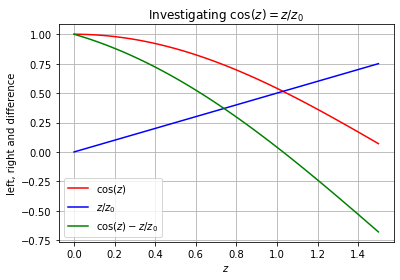

In [2]:
N=100
z0=2.0
z=np.linspace(0,1.5,N)

def leftS(z):
    return np.cos(z)

def rightS(z,z0=z0):
    return z/z0

def f(z,z0=z0):
    return leftS(z)-rightS(z,z0)

pl.grid()
pl.title("Investigating $\cos(z)=z/z_0$")
pl.ylabel("left, right and difference")
pl.xlabel("$z$")
pl.plot(z,leftS(z),'r-',label='$\cos(z)$')
pl.plot(z, rightS(z),'b-',label='$z/z_0$')
pl.plot(z, f(z),'g-', label='$\cos(z)-z/z_0$')
pl.legend(loc=3)

In [4]:
def fp(z):
    """
    We need a function to evaluate the derivative of f(z) for Newton's method.
    """
    return -np.sin(z)-1.0/z0

def newtonsMethod(f, fp, zi, eps=1e-15, Nmax=100, showCount=False):
    """
    Very simple implementation of Newton's Method.
    Try to find a zero of 'f' near zi to within eps.
    Don't use up over Nmax iterations
    """

    z=zi        # start at zi
    y=f(z)      # evaluate y
    count=0     # start count at zero
    
    while (abs(y)>eps) and count<Nmax:
        dz=y/fp(z)  # evaluate dz
        z=z-dz      # update z
        y=f(z)      # update y
        count += 1  # update count
        
    if count>=Nmax:
        raise RuntimeError("Ack! I can't find a zero.")
    elif showCount:
        print( "Found root", z, "in", count, "iterations. y=", y)
        
    return z

z = newtonsMethod(f, fp, 1.0, showCount=True)


Found root 1.0298665293222589 in 3 iterations. y= 0.0


In [5]:
from scipy.optimize import brentq
print (brentq(f, 0.9, 1.1))

1.0298665293222566


Suppose we have some potential function and we want to find a "bound state" wavefunction that satisfies the boundary conditions of the potential. There are of course many different possible potentials that could be considered. Let's focus on a class that goes to infinity for $x<0$ and $x>L$. Between those limits the potential is defined by a function $V(x)$.

We can ues RK4 to integrate from $x=0$ to $x=L$. What shall we integrate? The Schrodinger Wave Equation of course!

$$-\frac{\hbar^2}{2m} \psi''(x) + V(x)\psi(x) = E\psi(x)$$

$$\psi'' = \frac{2m}{\hbar^2}\left(V(x)-E\right)\psi(x)$$


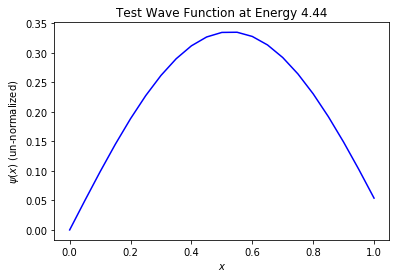

In [9]:
def V(x, a=3.0):
    """
    Here's an example potential V(x)=0.0
    """
    return 0.0

psi0, psip0 = 0.0, 1.0   # start psi and psi'  at $x=0$.
s=np.array([psi0, psip0])

hbar=1.0  # pick convenient units
m=1.0
L=1.0

x=0.0
dx=L/20
E=0.90*(hbar**2/(2*m))*(np.pi/L)**2  # start at 90% of known ground state energy.

xList=[x]         # put in the first value
psiList=[psi0]

def RK4Step(s, x, derivs, dx, E):
    """
    Take a single RK4 step. (our old friend)
    But this time we're integrating in 'x', not 't'.
    """
    dxh=dx/2.0
    f1 = derivs(s, x, E)
    f2 = derivs(s+f1*dxh, x+dxh, E)
    f3 = derivs(s+f2*dxh, x+dxh, E)
    f4 = derivs(s+f3*dx, x+dx, E)
    return s + (f1+2*f2+2*f3+f4)*dx/6.0

def SWE_derivs(s, x, E):
    psi=s[0]
    psip=s[1]
    
    psipp =(2*m/hbar**2)*(V(x)-E)*psi
    return np.array([psip, psipp])

while x<=L:
    s=RK4Step(s, x, SWE_derivs, dx, E)
    x+=dx
    xList.append(x)
    psiList.append(s[0])
    
pl.title("Test Wave Function at Energy %3.2f" % E)
pl.ylabel("$\psi(x)$ (un-normalized)")
pl.xlabel("$x$")
pl.plot(xList, psiList, 'b-')

In [12]:
def calcBC(E):
    """
    Compute the value of psi(x) at x=L for a given value of E
    assuming psi(0) is zero.
    """
    s=np.array([psi0, psip0])
    x=0.0
    while x<L:
        s=RK4Step(s, x, SWE_derivs, dx, E)
        x+=dx

    return s[0]


In [13]:
print ("BC at E=4.4:",calcBC(4.4))
print ("BC at E=5.4:",calcBC(5.4))

BC at E=4.4: 0.058733291081520776
BC at E=5.4: -0.04388409670425276


In [14]:
Ezero = brentq(calcBC, 4.4, 5.4)  # find "root" with brentq
Ezero

4.9348518337322735

In [16]:
print( ((hbar**2)/(2*m))*(np.pi/L)**2  )# exact result

4.934802200544679


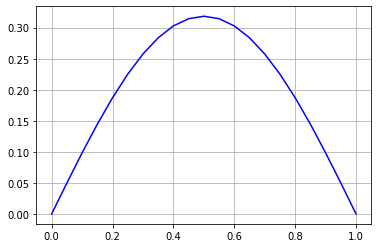

In [18]:
def calcBC_wPsi(E):
    """
    Compute the value of psi(x) at x=L for a given value of E
    assuming psi(0) is zero.
    """
    s=np.array([psi0, psip0])
    x=0.0
    xList=[x]
    psiList=[psi0]
    
    while x<L:
        s=RK4Step(s, x, SWE_derivs, dx, E)
        x+=dx
        xList.append(x)
        psiList.append(s[0])

    return xList, psiList

xList, psiList = calcBC_wPsi(Ezero)
pl.plot(xList, psiList, 'b-')
pl.grid()

Project 9: (Option A) Find Energy States of a Different Potential
==============================

1. Pick a different potential. 
2. Modify the code provided to compute energy states of this potential.
3. Produce graphs of the wavefunction in a few energy states
4. Find some way to validate your results.

Project 9: (Option B) Find the angle of a "Swing Ride"
=============================

You've no doubt seen a "swing ride" like so:

![Swing Ride](http://www.newridesforsale.com/wp-content/uploads/2015/08/Beston-sky-swings-tower-ride.jpg)

1. Write out the momentum principle for a rider. 

2. Assume the mount point of chain is 3m from the axis and the chain is 5m long. Assume the ride has a period of rotation of 3 sec.

3. Find a transcendental equation that you can solve to get the angle of the swing.

4. Use Newon's Method to find the solution

5. Use the scipy.optimize brentq function to check your result.

Here is a rough diagram of the sitution:

![swing diagram](imgs/SwingRideRootFinding.png)

Of course the momentum principle says:

$$\frac{d\vec{p}}{dt} = \vec{F}_{\rm net}$$

Which, if you break it down into $x$ and $y$ componenets gives:

$$ \frac{m v^2}{R} = T \sin \theta $$

(where $\theta$ is the unknown angle between the vertical and the swing chain) and

$$ 0 = T \cos \theta - m g $$

Also, from the geometry:

$$ R = L + C \sin \theta $$

And so you have three unknown values: $R$, $T$ and $\theta$ ($m$ will cancel). You should be able to reduce this to one equation which you can solve by root finding.

Project 9: (Option C) Apply Root finding to any other problem: Surprise me!
=========================================

Just find any problem you like that results in a transcendental equation. Use some kind of sensible plan to find the roots of that equation in the context of the problem you've found.

